# Mean square displacement - Comparison of results from the event driven simulation and the numerical solution to SDE

## Import libraries and dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
from matplotlib import rc
import os
import sys
sys.path.append("../")

from scipy import stats
from scipy.optimize import curve_fit
from scipy.linalg import norm

from config import results_folder, plots_folder

## Plot details

In [2]:
plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \usepackage{bm}"]

## Utility functions

In [3]:
def read_and_return_msd_data(filenames, timestep, t_stop, runs):
    if timestep == 0:
        if t_stop >= 1000:
            times = np.zeros(101)
        else:
            times = np.zeros(51)
    else:
        times = np.arange(0, (int(t_stop/timestep)+1))*timestep
    msd_matrix = np.zeros((runs, len(times)))
    q_speed_matrix = np.zeros((runs, len(times)))
    for i in range(runs):
        filename = filenames.replace('X', str(i))
        msd_data = np.load(file=os.path.join(results_folder, filename))
        msd_matrix[i, :] = msd_data[:, 1]
        q_speed_matrix[i, :] = msd_data[:, 2]
        if timestep == 0:
            times = msd_data[:, 0]
    return times, np.mean(msd_matrix, axis=0), np.std(msd_matrix, axis=0), np.mean(q_speed_matrix, axis=0), np.std(q_speed_matrix, axis=0)

In [4]:
def log_function(t, scaling_factor):
    return np.log(t)*scaling_factor

In [5]:
def slope_function(t, scaling_factor):
    return t*scaling_factor

In [6]:
def tau_analytical(T0, xi, N, r, m=1):
    # Num and exp result China + Brilliantov and Poshel with a2=0
    n = N/1
    eta = n*4*np.pi*r**3/3
    g = (2-eta)/(2*(1-eta)**3)
    return (np.sqrt(T0/m)*(1-xi**2)/6*4*np.sqrt(np.pi)*g*(2*r)**2*n)**(-1)

def D0(T0, xi, N, r, m):
    n = N/1
    eta = n*4*np.pi*r**3/3
    g = (2-eta)/(2*(1-eta)**3)
    return 3*np.sqrt(T0)/((1+xi)**2*np.sqrt(m*np.pi)*n*g*(2*r)**2*2)

def gamma_1(T0, d0, m):
    return T0/(d0*m)

In [7]:
def msd_gg(t, d0, gamma0, tau):
    msd_1d = 2*d0*tau*(np.log(1+t/tau)+(1/(tau*gamma0))*((1+t/tau)**(-tau*gamma0)-1))
    return 3*msd_1d

def msd_udsbm(t, d0, gamma0, tau):
    msd_1d = 2*d0*tau**2*gamma0**2*(tau*np.log(1+t/tau)+(tau/(tau*gamma0-1))*((1+t/tau)**(-tau*gamma0+1)-1))/((tau*gamma0-1)**2)
    return 3*msd_1d

def msd_elasticparticles(t, d0, gamma0):
    msd_1d = 2*d0*t+2*d0*(np.exp(-gamma0*t)-1)/gamma0
    return 3*msd_1d

## MSD

In [8]:
def compare_msd(N, xi, r, tstop, timestep_values, runs, save_plot=False):
    filenames_gen = f"msd_Y_N_{N}_r_{r}_xi_{xi}_tstop_{tstop}_dt_Z_X.npy"
    file_changes = ["pbc_eq_start", "sde"]
    labels = ["Event driven simulation", "Numerical solution to SDE"]
    print(f'---------- xi: {xi} ------------')
    plt.figure()
    for i in range(len(file_changes)):
        filenames = filenames_gen.replace('Y', file_changes[i])
        filenames = filenames.replace('Z', str(timestep_values[i]))
        print(filenames)

        times, msd, std_msd, mss, std_mss = read_and_return_msd_data(filenames, timestep_values[i], tstop, runs)

        T0 = mss[0]/3

        times = times[1:]
        msd = msd[1:]
        std_msd = std_msd[1:]
        mss = mss[1:]
        std_mss = std_mss[1:]

        plt.loglog(times, msd, label=labels[i])
        
        if i == 1:
            if xi == 1:
                gamma0, d0 = 11.43, 0.058  # found from 3d simulations of molecular gas with xi=1 and eta = 0.065.
                theory = msd_elasticparticles(times, d0, gamma0)
                plt.plot(times, theory, '--', label='Theoretical values mg')

            else:
                d0, tau = D0(T0, xi, N, r, m=1), tau_analytical(T0, xi, N, r, m=1)
                gamma0 = gamma_1(T0, d0, m=1)
                tau = np.round(tau, decimals=2)
                gamma0 = np.round(gamma0, decimals=2)
                d0 = np.round(d0, decimals=3)
                theory = msd_udsbm(times, d0, gamma0, tau)
                plt.plot(times, msd_gg(times, d0, gamma0, tau), '--', label='Theoretical values gg')
                plt.plot(times, msd_udsbm(times, d0, gamma0, tau), '--', label='Theoretical values udsbm')
        
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\langle (\bm{x}(t)-\bm{x}_0)^2 \rangle$')
    # plt.title(r'$\xi={}$'.format(xi))
    plt.legend()
    if save_plot:
        plt.savefig(os.path.join(plots_folder, f'msd_compare_methods_N_{N}_xi_{xi}_rad_{rad}_tstop_{tstop}.pdf'))
    plt.show()
    print('-----------------------')

### Molecular gas (xi = 1)

---------- xi: 1.0 ------------
msd_pbc_eq_start_N_1000_r_0.025_xi_1.0_tstop_100_dt_0.0_X.npy
msd_sde_N_1000_r_0.025_xi_1.0_tstop_100_dt_0.01_X.npy


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


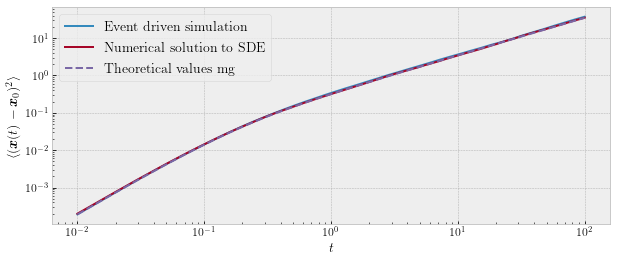

-----------------------


In [9]:
N = 1000
xi = 1.0
tstop = 100
rad = 0.025
timestep_val = [0.0, 0.01]
number_of_runs = 4

compare_msd(N, xi, rad, tstop, timestep_val, number_of_runs, save_plot=True)

### Underdamped Scaled Brownian motion -> granular gas (xi < 1)

---------- xi: 0.8 ------------
msd_pbc_eq_start_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.0_X.npy
msd_sde_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.01_X.npy


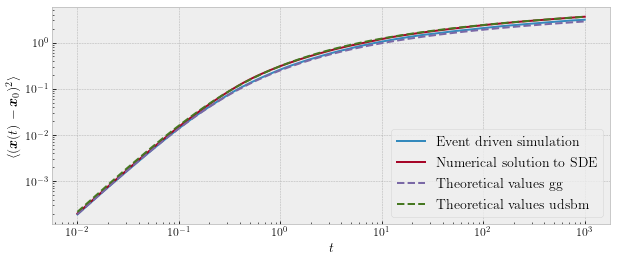

-----------------------


In [10]:
N = 1000
xi = 0.8
tstop = 1000
rad = 0.025
timestep_val = [0.0, 0.01]
number_of_runs = 4

compare_msd(N, xi, rad, tstop, timestep_val, number_of_runs, save_plot=True)

---------- xi: 0.5 ------------
msd_pbc_eq_start_N_1000_r_0.025_xi_0.5_tstop_1000_dt_0.1_X.npy
msd_sde_N_1000_r_0.025_xi_0.5_tstop_1000_dt_0.1_X.npy


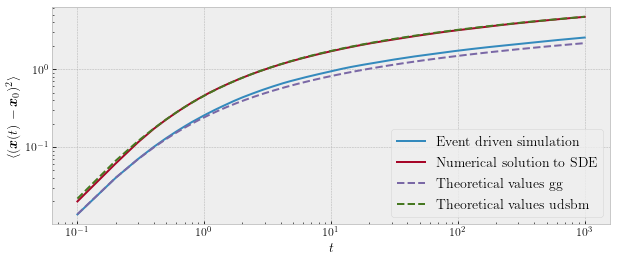

-----------------------


In [11]:
xi = 0.5
timestep_val = [0.1, 0.1]

compare_msd(N, xi, rad, tstop, timestep_val, number_of_runs, save_plot=True)